In [1]:
import pandas as pd
import numpy as np
import os
import re

#Data Preparation

In [2]:
def data_preprocess(root_dir):
  image_files = [] #Listing all Train image files
  label_files =[] #Listing all Train Label files
  for i in os.listdir(root_dir): # getting all train image directories
    path_1= os.path.join(root_dir,i)
    for k in os.listdir(path_1): # images from the directory
      path_2 = os.path.join(path_1,k) #
      image_files.append(path_2)

      label = re.sub('leftImg8bit','gtFine',path_2) 
      label = re.sub('image.jpg','label.png',label)

      label_files.append(label) # adding the corresponding annoted png 
  return image_files,label_files

In [3]:
# Creating Train dataset containing train_images and Train_annotated_images
train_root= 'idd20k_lite/leftImg8bit/train'
image_file, label_file = data_preprocess(train_root)

data_train = pd.DataFrame() # Creating a Dataset
data_train['image'] = image_file
data_train['image'] = sorted(data_train['image'])

data_train['label'] = label_file
data_train['label'] = sorted(data_train['label'])

data_train.head()

,image,label
0,idd20k_lite/leftImg8bit/train/0/024541_image.jpg,idd20k_lite/gtFine/train/0/024541_label.png
1,idd20k_lite/leftImg8bit/train/0/024703_image.jpg,idd20k_lite/gtFine/train/0/024703_label.png
2,idd20k_lite/leftImg8bit/train/1/092468_image.jpg,idd20k_lite/gtFine/train/1/092468_label.png
3,idd20k_lite/leftImg8bit/train/1/340676_image.jpg,idd20k_lite/gtFine/train/1/340676_label.png
4,idd20k_lite/leftImg8bit/train/1/502201_image.jpg,idd20k_lite/gtFine/train/1/502201_label.png


In [4]:
# Creating Val dataset  containing val_images and val_annotated_images

val_root = 'idd20k_lite/leftImg8bit/val'
image_file , label_file = data_preprocess(val_root)

data_val = pd.DataFrame()
data_val['image'] = image_file
data_val['image'] = sorted(data_val['image'])

data_val['label'] = label_file
data_val['label'] = sorted(data_val['label'])

data_val.head()

,image,label
0,idd20k_lite/leftImg8bit/val/119/903127_image.jpg,idd20k_lite/gtFine/val/119/903127_label.png
1,idd20k_lite/leftImg8bit/val/132/475092_image.jpg,idd20k_lite/gtFine/val/132/475092_label.png
2,idd20k_lite/leftImg8bit/val/132/489315_image.jpg,idd20k_lite/gtFine/val/132/489315_label.png
3,idd20k_lite/leftImg8bit/val/132/874777_image.jpg,idd20k_lite/gtFine/val/132/874777_label.png
4,idd20k_lite/leftImg8bit/val/147/425716_image.jpg,idd20k_lite/gtFine/val/147/425716_label.png


# Segmentation Models

##Unet

In [ ]:
!pip install -U segmentation-models

In [ ]:
!pip install tensorflow==2.2.0

In [7]:
import tensorflow as tf
# tf.enable_eager_execution()
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
# from hilbert import hilbertCurve
import imgaug.augmenters as iaa
# import albumentations as A
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [8]:
import segmentation_models as sm
sm.set_framework('tf.keras')
from segmentation_models import Unet
tf.keras.backend.set_image_data_format('channels_last')

Segmentation Models: using `tf.keras` framework.


In [9]:
backbone = 'resnet34'
preprocess_input = sm.get_preprocessing(backbone)

In [10]:
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [11]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()

# https://analyticsindiamag.com/my-experiment-with-unet-building-an-image-segmentation-model/
# https://segmentation-models.readthedocs.io/en/latest/tutorial.html?highlight=get_preprocessing#simple-training-pipeline

class Dataset:
    # we will be modifying this CLASSES according to your data/problems
    CLASSES = ['drivable','non-drivable','living things','vehicles','road-side objects','far-objects','sky']
    
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self, df, classes=None):
        
        self.id = df.values
        # the paths of images
        self.image_fps = [images[0] for images in self.id]
        # the paths of segmentation images
        self.mask_fps = [masks[1] for masks in self.id]
        # giving labels for each class
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.image_fps[i], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image, (256, 256), interpolation = cv2.INTER_AREA)
        #image = preprocess_input(image)
        image = np.float32(image)/255

        label = np.zeros((256,256,7))
        mask  = cv2.imread(self.mask_fps[i])
        mask = cv2.resize(mask, (256, 256))
        img_1 = mask[:,:,0]
        for i in self.class_values:
          label[:,:,i] = (img_1 == i).astype(int)
        #image_masks = [(image_mask == v) for v in self.class_values]
        #image_mask = np.stack(image_masks, axis=-1).astype('float')

        # We are only using 4 augmantation techniques
        a = np.random.uniform()
        if a<0.25:
            image = aug2.augment_image(image)
            image_mask = aug2.augment_image(label)
        elif a<0.5:
            image = aug3.augment_image(image)
            image_mask = aug3.augment_image(label)
        elif a<0.75:
            image = aug4.augment_image(image)
            image_mask = aug4.augment_image(label)
        else:
            image = aug5.augment_image(image)
            image_mask = label
        #else:
            #image = aug6.augment_image(image)
            #image_mask = aug6.augment_image(image_mask)
            
        return image, image_mask
        
    def __len__(self):
        return len(self.id)


class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)


In [12]:
CLASSES = ['drivable','non-drivable','living things','vehicles','road-side objects','far-objects','sky']

train_dataset = Dataset(data_train, classes=CLASSES)
test_dataset  = Dataset(data_val, classes=CLASSES)

BATCH_SIZE=8
train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)

(8, 256, 256, 3)
(8, 256, 256, 7)


In [13]:
tf.keras.backend.clear_session()
unet_model = Unet(backbone, encoder_weights='imagenet', classes=7 , activation='softmax', input_shape=(256,256,3),encoder_freeze = True, decoder_block_type = 'upsampling')
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [14]:
def MIoU_score(y_val, y_pred):
    class_iou = []
    classes = 7
    
    y_predi = np.argmax(y_pred, axis=3)
    y_truei = np.argmax(y_val, axis=3)
    
    for c in range(classes):
        TP = np.sum((y_truei == c) & (y_predi == c))
        FP = np.sum((y_truei != c) & (y_predi == c))
        FN = np.sum((y_truei == c) & (y_predi != c)) 
        IoU = TP / float(TP + FP + FN)
        if(float(TP + FP + FN) == 0):
          IoU=TP/0.001
        class_iou.append(IoU)
    MIoU=sum(class_iou)/classes
    return MIoU

In [15]:
def miou( y_true, y_pred ) :
    score = tf.py_function( lambda y_true, y_pred : MIoU_score( y_true, y_pred).astype('float32'),
                        [y_true, y_pred],
                        'float32')
    return score

In [16]:
%load_ext tensorboard

In [17]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint,TensorBoard,ReduceLROnPlateau
from segmentation_models.metrics import iou_score
import datetime

optim = tf.keras.optimizers.Adam()
unet_model.compile(optim, loss='categorical_crossentropy', metrics=[miou])


checkpoint = ModelCheckpoint('./best_model1.h5', save_weights_only=True,save_best_only=True, mode='max', monitor='val_miou',verbose=1)
red = ReduceLROnPlateau(monitor='val_miou', min_lr=0.00001,patience=2,verbose=1)
log_dir = os.path.join("logs_1", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq= 1,write_graph=True)
callback_list = [checkpoint,tensorboard_callback]

In [18]:
history = unet_model.fit_generator(train_dataloader, steps_per_epoch=100, epochs=20,validation_data=test_dataloader,callbacks=callback_list)

Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.9530 - miou: 0.2951
Epoch 00001: val_miou improved from -inf to 0.03874, saving model to ./best_model1.h5
100/100 [==============================] - 450s 5s/step - loss: 0.9530 - miou: 0.2951 - val_loss: 3.3957 - val_miou: 0.0387
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.6421 - miou: 0.3780
Epoch 00002: val_miou improved from 0.03874 to 0.05044, saving model to ./best_model1.h5
100/100 [==============================] - 439s 4s/step - loss: 0.6421 - miou: 0.3780 - val_loss: 4.0285 - val_miou: 0.0504
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.5655 - miou: 0.3971
Epoch 00003: val_miou improved from 0.05044 to 0.07380, saving model to ./best_model1.h5
100/100 [==============================] - 441s 4s/step - loss: 0.5655 - miou: 0.3971 - val_loss: 2.3593 - val_miou: 0.0738
Epoch 4/20
100/100 [==============================] - ETA: 0s - loss: 0.4862 - miou: 0.4

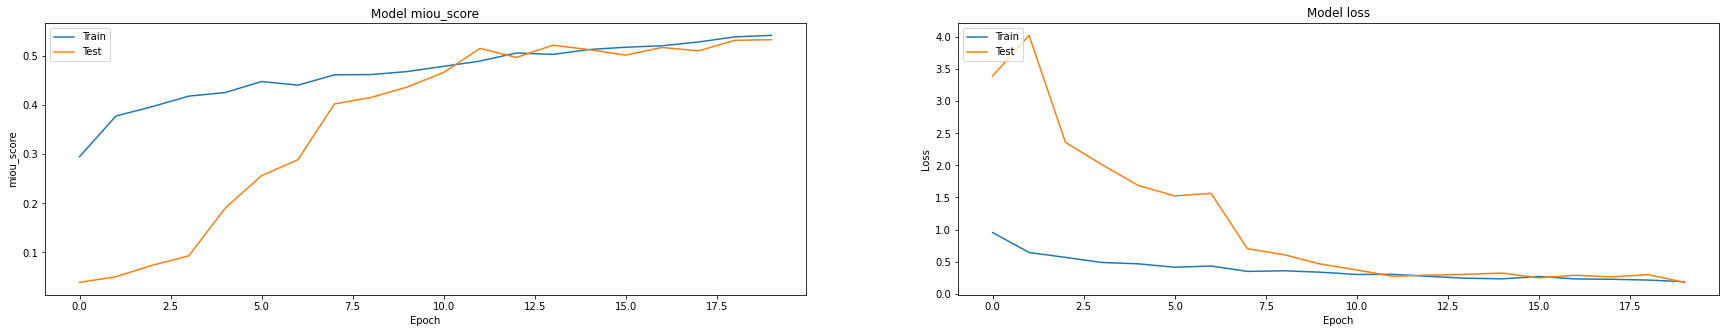

In [20]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['miou'])
plt.plot(history.history['val_miou'])
plt.title('Model miou_score')
plt.ylabel('miou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Observation

Unet model attained a train MIoU score of 0.5423 and a val MIoU score of 0.5334

##PSPNet

In [22]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()

# https://analyticsindiamag.com/my-experiment-with-unet-building-an-image-segmentation-model/
# https://segmentation-models.readthedocs.io/en/latest/tutorial.html?highlight=get_preprocessing#simple-training-pipeline

class Dataset:
    # we will be modifying this CLASSES according to your data/problems
    CLASSES = ['drivable','non-drivable','living things','vehicles','road-side objects','far-objects','sky']
    
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self, df, classes=None):
        
        self.id = df.values
        # the paths of images
        self.image_fps = [images[0] for images in self.id]
        # the paths of segmentation images
        self.mask_fps = [masks[1] for masks in self.id]
        # giving labels for each class
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.image_fps[i], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image, (240, 240), interpolation = cv2.INTER_AREA)
        #image = preprocess_input(image)
        image = np.float32(image)/255

        label = np.zeros((240,240,7))
        mask  = cv2.imread(self.mask_fps[i])
        mask = cv2.resize(mask, (240, 240))
        img_1 = mask[:,:,0]
        for i in self.class_values:
          label[:,:,i] = (img_1 == i).astype(int)
        #image_masks = [(mask == v) for v in self.class_values]
        #image_mask = np.stack(image_masks, axis=0).astype('float')

        # We are only using 4 augmantation techniques
        a = np.random.uniform()
        if a<0.25:
            image = aug2.augment_image(image)
            image_mask = aug2.augment_image(label)
        elif a<0.5:
            image = aug3.augment_image(image)
            image_mask = aug3.augment_image(label)
        elif a<0.75:
            image = aug4.augment_image(image)
            image_mask = aug4.augment_image(label)
        else:
            image = aug5.augment_image(image)
            image_mask = label
            
        return image, image_mask
        
    def __len__(self):
        return len(self.id)


class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [23]:
CLASSES = ['drivable','non-drivable','living things','vehicles','road-side objects','far-objects','sky']

train_dataset = Dataset(data_train, classes=CLASSES)
test_dataset  = Dataset(data_val, classes=CLASSES)

BATCH_SIZE=8
train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)

(8, 240, 240, 3)
(8, 240, 240, 7)


In [24]:
from segmentation_models import PSPNet

tf.keras.backend.clear_session()
psp_net_model = PSPNet(backbone, encoder_weights='imagenet', classes=7 , activation='softmax', input_shape=(240,240,3),encoder_freeze = True)
psp_net_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 240, 240, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 246, 246, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 120, 120, 64) 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [25]:
optim = tf.keras.optimizers.Adam()
psp_net_model.compile(optim, loss='categorical_crossentropy', metrics=[miou])

checkpoint = ModelCheckpoint('./best_model2.h5', save_weights_only=True,save_best_only=True, mode='max', monitor='val_miou',verbose=1)
log_dir = os.path.join("logs_2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq= 1,write_graph=True)
callback_list = [checkpoint,tensorboard_callback]

In [26]:
history = psp_net_model.fit_generator(train_dataloader, steps_per_epoch=100, epochs=20,validation_data=test_dataloader,callbacks=callback_list)

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.8781 - miou: 0.3464
Epoch 00001: val_miou improved from -inf to 0.04280, saving model to ./best_model2.h5
100/100 [==============================] - 149s 1s/step - loss: 0.8781 - miou: 0.3464 - val_loss: 1.8446 - val_miou: 0.0428
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.6430 - miou: 0.4050
Epoch 00002: val_miou improved from 0.04280 to 0.04805, saving model to ./best_model2.h5
100/100 [==============================] - 146s 1s/step - loss: 0.6430 - miou: 0.4050 - val_loss: 2.3672 - val_miou: 0.0480
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.5720 - miou: 0.4325
Epoch 00003: val_miou improved from 0.04805 to 0.05429, saving model to ./best_model2.h5
100/100 [==============================] - 145s 1s/step - loss: 0.5720 - miou: 0.4325 - val_loss: 2.6655 - val_miou: 0.0543
Epoch 4/20
100/100 [==============================] - ETA: 0s - loss: 0.5172 - miou: 0.4

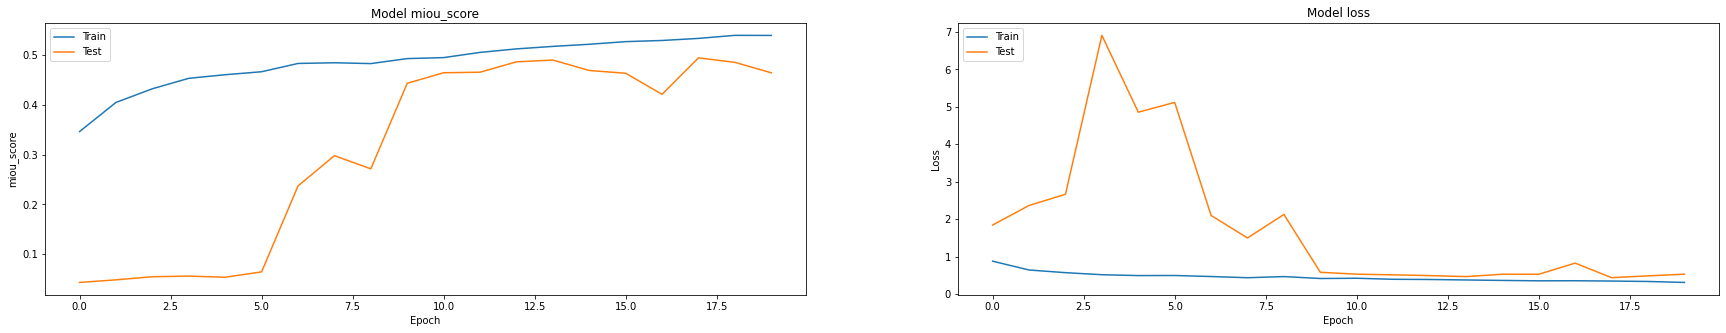

In [28]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['miou'])
plt.plot(history.history['val_miou'])
plt.title('Model miou_score')
plt.ylabel('miou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Observation 

In the case of PSPNet segmentation model, we attained a train MIoU score of 0.5399 and val MIoU score of 0.4946

##LINKnet

In [39]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()

# https://analyticsindiamag.com/my-experiment-with-unet-building-an-image-segmentation-model/
# https://segmentation-models.readthedocs.io/en/latest/tutorial.html?highlight=get_preprocessing#simple-training-pipeline

class Dataset:
    # we will be modifying this CLASSES according to your data/problems
    CLASSES = ['drivable','non-drivable','living things','vehicles','road-side objects','far-objects','sky']
    
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self, df, classes=None):
        
        self.id = df.values
        # the paths of images
        self.image_fps = [images[0] for images in self.id]
        # the paths of segmentation images
        self.mask_fps = [masks[1] for masks in self.id]
        # giving labels for each class
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.image_fps[i], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image, (256, 256), interpolation = cv2.INTER_AREA)
        #image = preprocess_input(image)
        image = np.float32(image)/255

        label = np.zeros((256,256,7))
        mask  = cv2.imread(self.mask_fps[i])
        mask = cv2.resize(mask, (256, 256), interpolation = cv2.INTER_AREA)
        img_1 = mask[:,:,0]
        for i in self.class_values:
          label[:,:,i] = (img_1 == i).astype(int)
        #image_masks = [(mask == v) for v in self.class_values]
        #image_mask = np.stack(image_masks, axis=0).astype('float')

        # We are only using 4 augmantation techniques
        a = np.random.uniform()
        if a<0.25:
            image = aug2.augment_image(image)
            image_mask = aug2.augment_image(label)
        elif a<0.5:
            image = aug3.augment_image(image)
            image_mask = aug3.augment_image(label)
        elif a<0.75:
            image = aug4.augment_image(image)
            image_mask = aug4.augment_image(label)
        else:
            image = aug5.augment_image(image)
            image_mask = label
            
        return image, image_mask
        
    def __len__(self):
        return len(self.id)


class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [48]:
CLASSES = ['drivable','non-drivable','living things','vehicles','road-side objects','far-objects','sky']

train_dataset = Dataset(data_train, classes=CLASSES)
test_dataset  = Dataset(data_val, classes=CLASSES)

BATCH_SIZE=8
train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)

(8, 256, 256, 3)
(8, 256, 256, 7)


In [35]:
from segmentation_models import Linknet

tf.keras.backend.clear_session()
linknet_model = Linknet(backbone_name='vgg16', encoder_weights='imagenet', classes=7 , activation='softmax', input_shape=(256,256,3),encoder_freeze = True)
linknet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [41]:
optim = tf.keras.optimizers.Adam()
linknet_model.compile(optim, loss='categorical_crossentropy', metrics=[miou])

checkpoint = ModelCheckpoint('./best_model3.h5', save_weights_only=True,save_best_only=True, mode='max', monitor='val_miou',verbose=1)
log_dir = os.path.join("logs_3", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq= 1,write_graph=True)
callback_list = [checkpoint,tensorboard_callback]

In [50]:
history = linknet_model.fit_generator(train_dataloader, steps_per_epoch=100, epochs=20,validation_data=test_dataloader,callbacks=callback_list)

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.7049 - miou: 0.3219
Epoch 00001: val_miou improved from -inf to 0.31523, saving model to ./best_model4.h5
100/100 [==============================] - 438s 4s/step - loss: 0.7049 - miou: 0.3219 - val_loss: 1.1161 - val_miou: 0.3152
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.6194 - miou: 0.3602
Epoch 00002: val_miou improved from 0.31523 to 0.37717, saving model to ./best_model4.h5
100/100 [==============================] - 437s 4s/step - loss: 0.6194 - miou: 0.3602 - val_loss: 0.6263 - val_miou: 0.3772
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.5458 - miou: 0.3833
Epoch 00003: val_miou improved from 0.37717 to 0.37732, saving model to ./best_model4.h5
100/100 [==============================] - 432s 4s/step - loss: 0.5458 - miou: 0.3833 - val_loss: 0.6153 - val_miou: 0.3773
Epoch 4/20
100/100 [==============================] - ETA: 0s - loss: 0.4852 - miou: 0.3

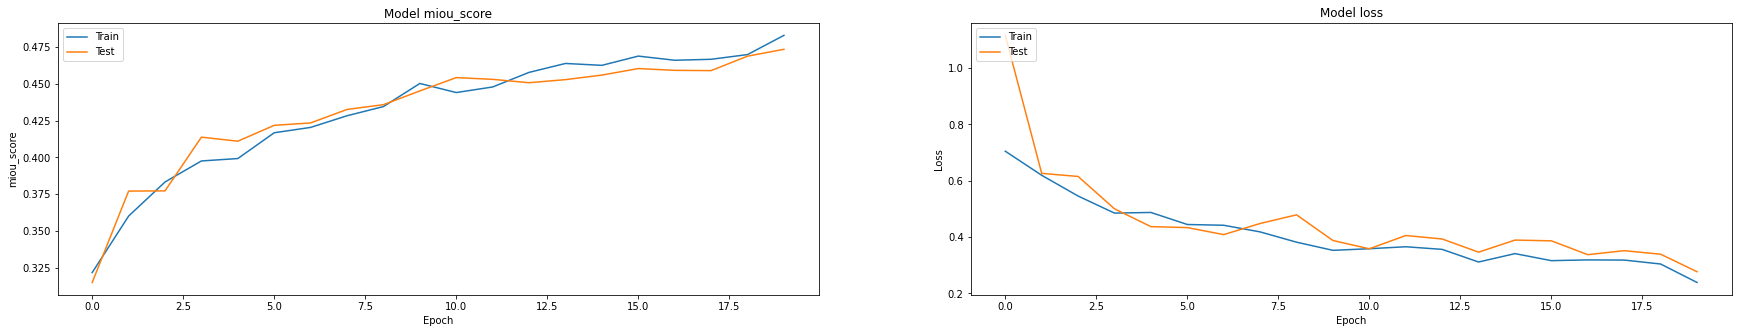

In [52]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['miou'])
plt.plot(history.history['val_miou'])
plt.title('Model miou_score')
plt.ylabel('miou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Observation

Here in the case of Linknet segmentation model, we attain a train MIoU score of 0.4828 and a val MIoU score of 0.4733 

##FPN

In [53]:
from segmentation_models import FPN

tf.keras.backend.clear_session()
fpn_model = Linknet(backbone_name='vgg16', encoder_weights='imagenet', classes=7 , activation='softmax', input_shape=(256,256,3),encoder_freeze = True)
fpn_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [54]:
optim = tf.keras.optimizers.Adam()
fpn_model.compile(optim, loss='categorical_crossentropy', metrics=[miou])

checkpoint = ModelCheckpoint('./best_model4.h5', save_weights_only=True,save_best_only=True, mode='max', monitor='val_miou',verbose=1)
log_dir = os.path.join("logs_4", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq= 1,write_graph=True)
callback_list = [checkpoint,tensorboard_callback]

In [55]:
history = fpn_model.fit_generator(train_dataloader, steps_per_epoch=100, epochs=20,validation_data=test_dataloader,callbacks=callback_list)

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 1.1443 - miou: 0.2372
Epoch 00001: val_miou improved from -inf to 0.25235, saving model to ./best_model4.h5
100/100 [==============================] - 404s 4s/step - loss: 1.1443 - miou: 0.2372 - val_loss: 1.8378 - val_miou: 0.2523
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.7127 - miou: 0.3307
Epoch 00002: val_miou improved from 0.25235 to 0.33846, saving model to ./best_model4.h5
100/100 [==============================] - 403s 4s/step - loss: 0.7127 - miou: 0.3307 - val_loss: 0.9920 - val_miou: 0.3385
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.5907 - miou: 0.3652
Epoch 00003: val_miou improved from 0.33846 to 0.36376, saving model to ./best_model4.h5
100/100 [==============================] - 403s 4s/step - loss: 0.5907 - miou: 0.3652 - val_loss: 0.7589 - val_miou: 0.3638
Epoch 4/20
100/100 [==============================] - ETA: 0s - loss: 0.5631 - miou: 0.3

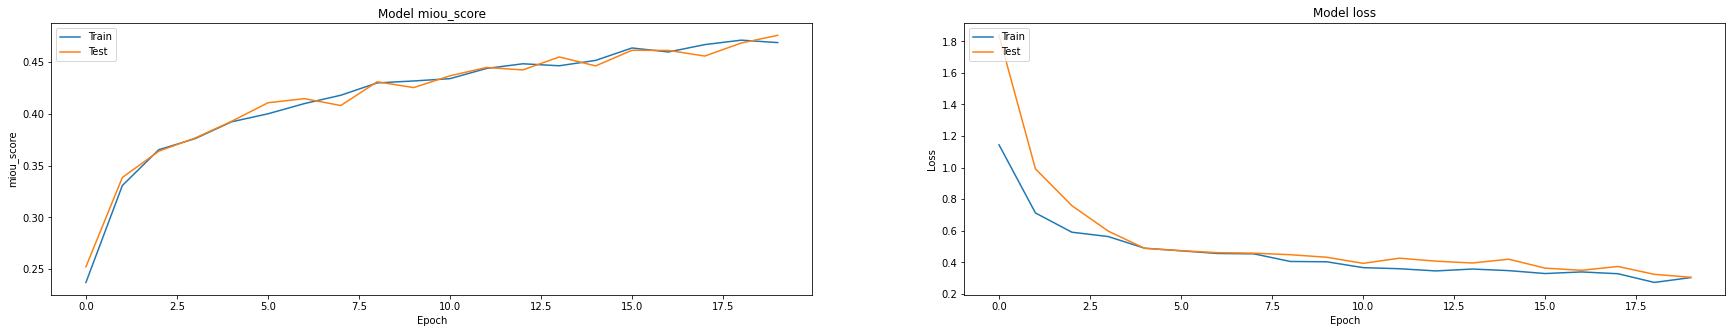

In [57]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['miou'])
plt.plot(history.history['val_miou'])
plt.title('Model miou_score')
plt.ylabel('miou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Observation

Here in the case of FPN segmentation model, we attain a train MIoU score of 0.4685 and a val MIoU score of 0.4755

# Conclusion

In [1]:
from prettytable import *
x = PrettyTable()
x.field_names = ['Model','Train MIoU','Val MIoU']
x.add_row(['Unet','0.5423','0.5334'])
x.add_row(['PSPNet','0.5398','0.4946'])
x.add_row(['Linknet','0.4828' ,'0.4733'])
x.add_row(['FPN','0.4685','0.4755'])
print(x)

+---------+------------+----------+
|  Model  | Train MIoU | Val MIoU |
+---------+------------+----------+
|   Unet  |   0.5423   |  0.5334  |
|  PSPNet |   0.5398   |  0.4946  |
| Linknet |   0.4828   |  0.4733  |
|   FPN   |   0.4685   |  0.4755  |
+---------+------------+----------+


We can observe that U-net model has performed better than all the other segmentation models with a train MIoU score of 0.54 and val MIoU score of 0.53. 